In [6]:
from mpytools import Catalog
import utils
import glob
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

target_4m_lrg = Catalog.read(glob.glob('/pscratch/sd/a/arocher/4MOST/target_lrg_4most_v2.fits'))
mask_pixmap = Catalog.read('/pscratch/sd/e/edmondc/antoine/Legacy_Imaging_DR10_footprint_128.fits')
features_pixmap = Catalog.read('/pscratch/sd/e/edmondc/antoine/pixweight-dr10-128-new.fits')




In [21]:
regression_type = 'RF'

all_feature_names = ['STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'PSFDEPTH_W1', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']
nfold = 2
use_kfold = True
nside=128 
targets = utils.create_hp_map(target_4m_lrg['RA'], target_4m_lrg['DEC'], nside=nside, nest=True)
#targets = utils.apply_mask_to_hpmap(hpmap, mask=mask_pixmap['ISNGC'])
#utils.plot_moll(targets, rot=115, min=300, max=600, desi_footprint=False, fourmost_footprint=True, label='deg-2', nest=True)
region = mask_pixmap['ISDES'] #& mask_pixmap['IS4MOST_LRG']
pix_to_use_norm = region & (targets >0)
fracarea = features_pixmap['FRACAREA_12290']

keep_to_train = (fracarea > np.quantile(fracarea[fracarea>0], q=0.05)) & (targets > 0) & region 
#utils.plot_moll(utils.apply_mask_to_hpmap(targets, mask=keep_to_train), rot=115, min=300, max=600, desi_footprint=False, fourmost_footprint=True, label='deg-2', nest=True)

normalized_targets = np.zeros_like(targets)
mean_targets_density_estimators = np.mean(targets[keep_to_train] / fracarea[keep_to_train])
normalized_targets[keep_to_train] = targets[keep_to_train] / (fracarea[keep_to_train] * mean_targets_density_estimators)

#utils.plot_moll(normalized_targets, rot=115, min=0.5, max=1.5, desi_footprint=False, fourmost_footprint=True, label='deg-2', nest=True)



region_to_pred = mask_pixmap['ISDES'] #& mask_pixmap['IS4MOST_LRG']  # mask array
feature_names = all_feature_names

X = np.vstack([features_pixmap[v] for v in feature_names]).T
Y = normalized_targets
X_train, Y_train, X_eval, Y_eval = X[keep_to_train], Y[keep_to_train], X[region_to_pred], Y[region_to_pred]

Y_pred = np.zeros_like(targets)

Y_pred[keep_to_train] = utils.run_sys_regression(regression_type, X_train, Y_train, X_eval, keep_to_train, nfold=nfold, use_kfold = use_kfold)

w1 = np.zeros(hp.nside2npix(nside))
w1[Y_pred > 0] = 1.0 / Y_pred[Y_pred > 0]



nflod 0 is running
nflod 0 done
nflod 1 is running
nflod 1 done


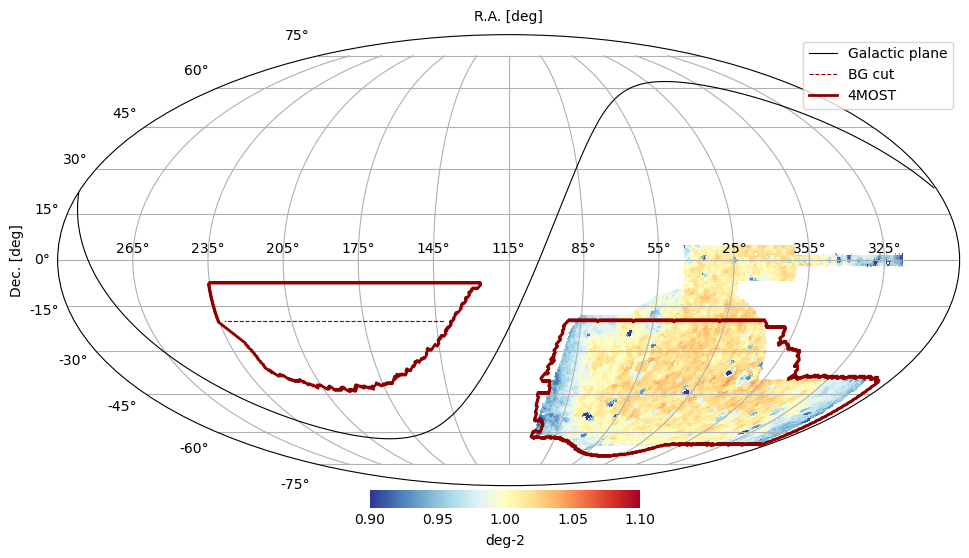

In [22]:
utils.plot_moll(w, rot=115, min=0.9, max=1.1, desi_footprint=False, fourmost_footprint=True, label='deg-2', nest=True)

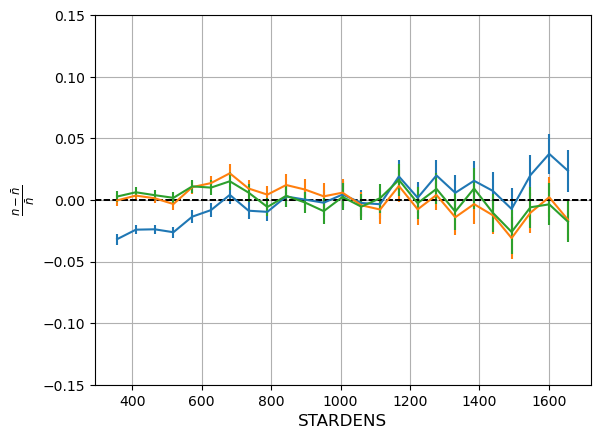

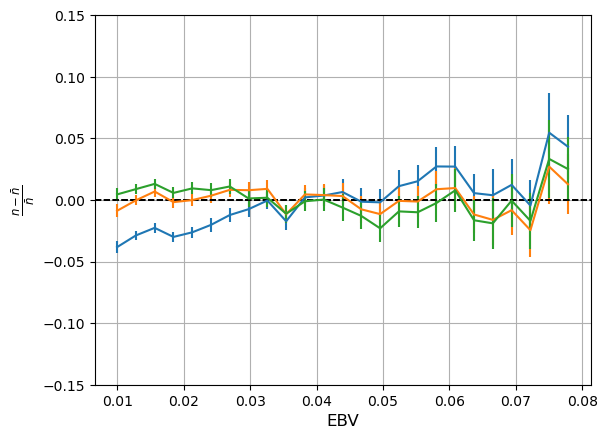

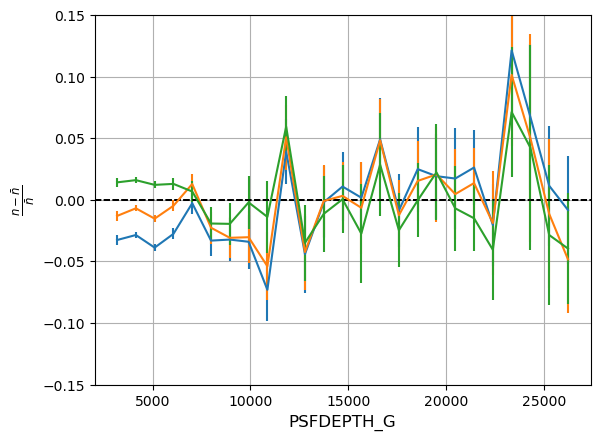

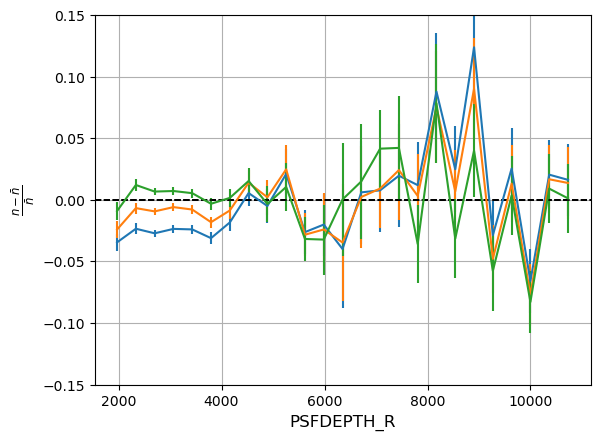

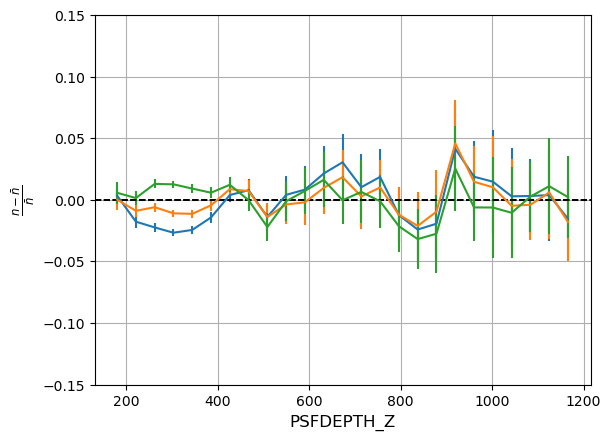

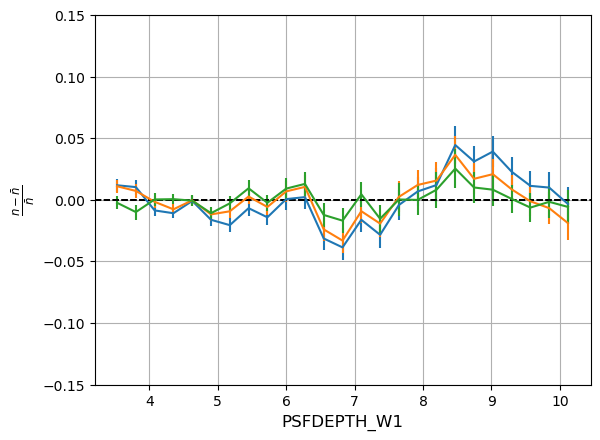

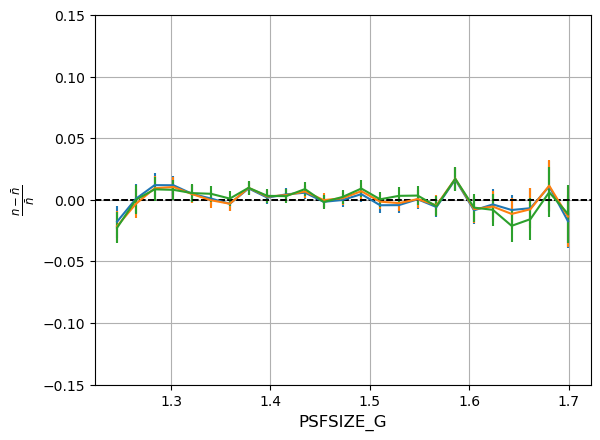

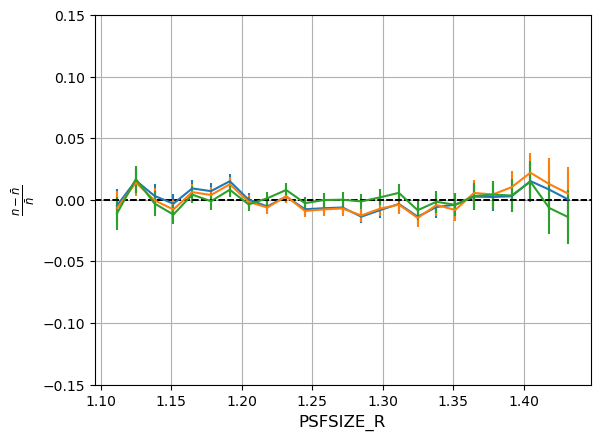

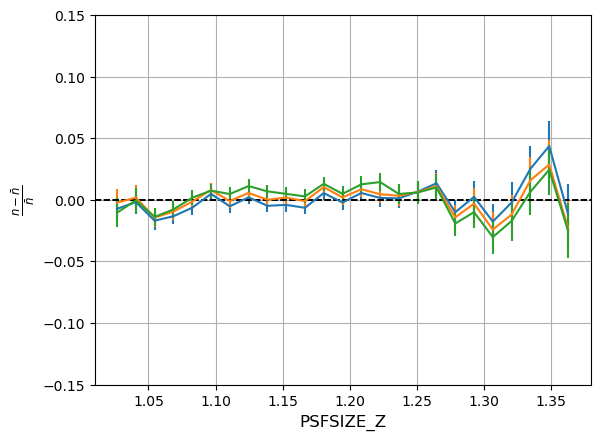

'keep_all = [np.all([keep_tot, weights*hpmap2/hpmap>=bins[i], weights*hpmap2/hpmap<bins[i+1]], axis=0) for i in range(nbins)]\nmean, std = np.array([np.mean((hpmap[mm]/n_bar)[hpmap[mm]/n_bar>0.1]) for mm in keep_all]), [np.std((hpmap[mm]/n_bar)[hpmap[mm]/n_bar>0.1])/np.sqrt(mm.sum()) for mm in keep_all]\n\nplt.errorbar(cbin, mean -1, [np.std(hpmap[mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all])'

In [23]:
for feature in feature_names:
    for tar in [targets, targets*w, targets*w1]:
        nbins=25
        #keep_tot = hpmap != 0.0
        keep_tot = region_to_pred
        #n_bar = np.mean(hpmap[keep_tot])
        n_bar =np.mean(tar[keep_tot])

        boundary = np.quantile(features_pixmap[feature][keep_tot], q=[0.02,0.98])
        counts, bins = np.histogram(features_pixmap[feature][keep_tot], bins=nbins, range=boundary)
        sizebin= np.diff(bins)[0]
        cbin = 0.5*(bins[1:]+bins[:-1])
        keep_all = [np.all([features_pixmap[feature][keep_tot]>=bins[i], features_pixmap[feature][keep_tot]<bins[i+1]], axis=0) for i in range(nbins)]
        mean, std = np.array([np.mean((tar[keep_tot][mm]/n_bar)[tar[keep_tot][mm]/n_bar>0.1]) for mm in keep_all]), [np.std(tar[keep_tot][mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all]

        #plt.errorbar(cbin, mean -1, [np.std(features_pixmap[feature_names][keep_tot][mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all])
        plt.errorbar(cbin, mean/mean.mean() -1, np.hstack(std))

        plt.axhline(0, ls='--', lw=1.2, c='k')
        plt.grid()
        plt.xlabel(feature, fontsize=12)
        plt.ylabel(r'$\frac{n-\bar n}{\bar n}$', fontsize=12)
        plt.ylim(-0.15,0.15)
    plt.show()

'''wtargets = targets * w
n_bar =np.mean(wtargets[keep_tot])

keep_all = [np.all([features_pixmap[feature][keep_tot]>=bins[i], features_pixmap[feature][keep_tot]<bins[i+1]], axis=0) for i in range(nbins)]
mean, std = np.array([np.mean((wtargets[keep_tot][mm]/n_bar)[wtargets[keep_tot][mm]/n_bar>0.1]) for mm in keep_all]), [np.std(wtargets[keep_tot][mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all]

#plt.errorbar(cbin, mean -1, [np.std(features_pixmap[feature_names][keep_tot][mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all])
plt.errorbar(cbin, mean/mean.mean() -1, np.hstack(std))
'''


'''keep_all = [np.all([keep_tot, weights*hpmap2/hpmap>=bins[i], weights*hpmap2/hpmap<bins[i+1]], axis=0) for i in range(nbins)]
mean, std = np.array([np.mean((hpmap[mm]/n_bar)[hpmap[mm]/n_bar>0.1]) for mm in keep_all]), [np.std((hpmap[mm]/n_bar)[hpmap[mm]/n_bar>0.1])/np.sqrt(mm.sum()) for mm in keep_all]

plt.errorbar(cbin, mean -1, [np.std(hpmap[mm]/n_bar)/np.sqrt(mm.sum()) for mm in keep_all])'''
